# Momentum TV Lab

Visualize TradingView-style momentum stop-entry output from `momentum_strategy_tv.py`.

- Set `TIMEFRAME` to `daily`, `weekly`, or `monthly`
- Top panel: price + active long/short stop levels + entry/reversal markers
- Bottom panel: `MOM0` and `MOM1`



Momentum file: /home/unionhills/Projects/GitHub/trading-signals/out/momentum_tv/APO.csv
Loaded 782 rows for APO.
Plot window: 2023-02-14 to 2026-02-13
Events in window: 37


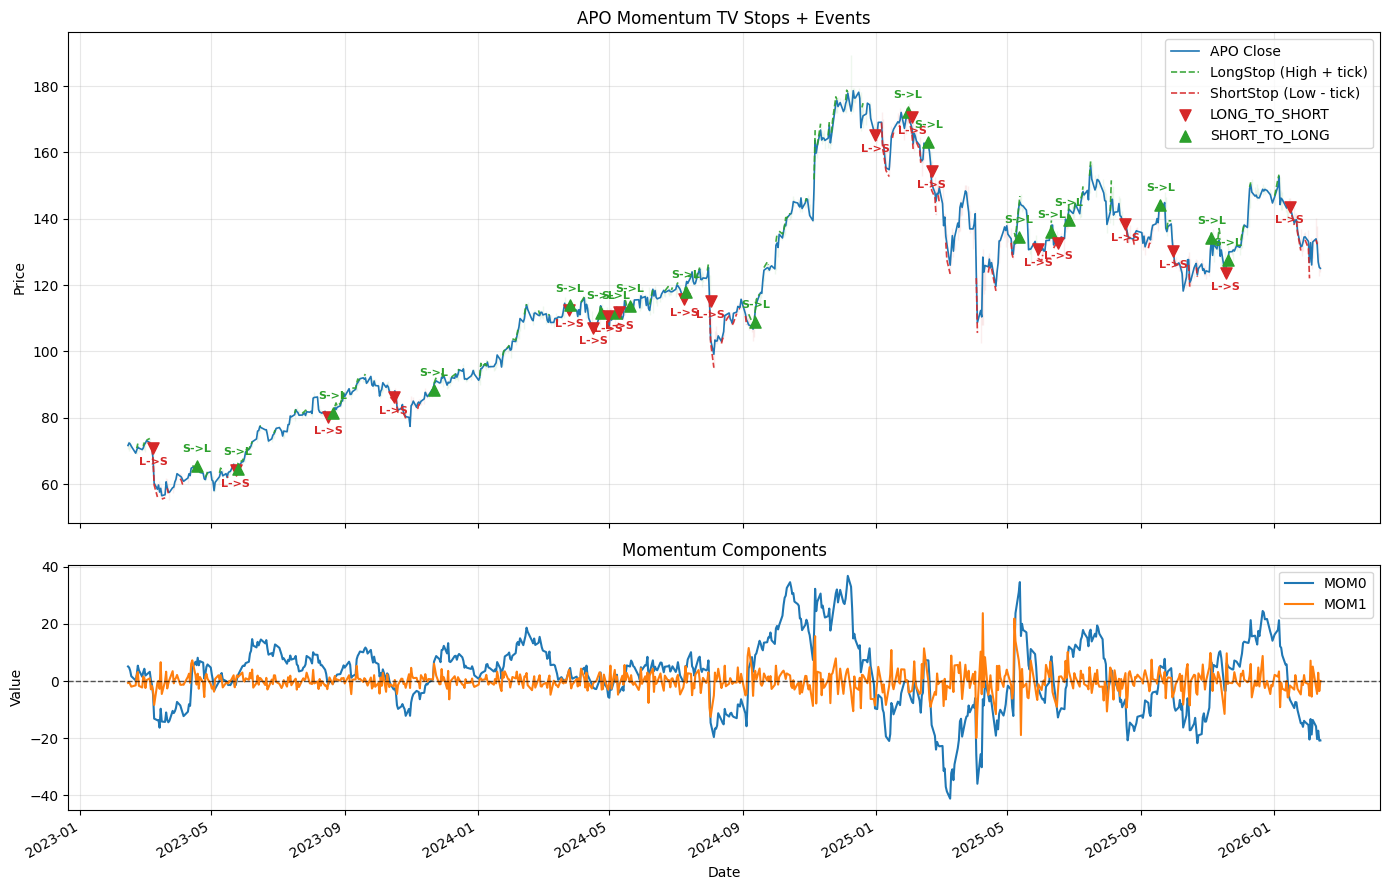


Latest 10 rows:
2026-02-02  Close=133.19  MOM0=-15.330000  MOM1=-1.020000  State=SHORT  Event=  Fill=133.610000
2026-02-03  Close=126.85  MOM0=-20.420000  MOM1=-5.090000  State=SHORT  Event=  Fill=131.120000
2026-02-04  Close=132.8  MOM0=-13.260000  MOM1=7.160000  State=SHORT  Event=  Fill=
2026-02-05  Close=126.08  MOM0=-18.680000  MOM1=-5.420000  State=SHORT  Event=  Fill=
2026-02-06  Close=133.03  MOM0=-13.580000  MOM1=5.100000  State=SHORT  Event=  Fill=
2026-02-09  Close=133.95  MOM0=-15.810000  MOM1=-2.230000  State=SHORT  Event=  Fill=
2026-02-10  Close=132.43  MOM0=-20.270000  MOM1=-4.460000  State=SHORT  Event=  Fill=133.640000
2026-02-11  Close=126.95  MOM0=-17.330000  MOM1=2.940000  State=SHORT  Event=  Fill=132.340000
2026-02-12  Close=125.37  MOM0=-20.820000  MOM1=-3.490000  State=SHORT  Event=  Fill=
2026-02-13  Close=125.07  MOM0=-20.750000  MOM1=0.070000  State=SHORT  Event=  Fill=


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "APO"
TIMEFRAME = "daily"  # daily | weekly | monthly
YEARS_TO_PLOT = 3  # Set to None to show full history


def resolve_data_dir(subdir: str) -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        target = candidate / "out" / subdir
        if target.exists():
            return target
    raise FileNotFoundError(
        f"Could not find out/{subdir}. Run Jupyter from repo root or notebooks/, and regenerate outputs first."
    )


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


timeframe_dir = {
    "daily": "momentum_tv",
    "weekly": "momentum_tv_weekly",
    "monthly": "momentum_tv_monthly",
}

timeframe_cmd = {
    "daily": "python3 momentum_strategy_tv.py --timeframe daily",
    "weekly": "python3 momentum_strategy_tv.py --timeframe weekly",
    "monthly": "python3 momentum_strategy_tv.py --timeframe monthly",
}

if TIMEFRAME not in timeframe_dir:
    raise ValueError("TIMEFRAME must be one of: daily, weekly, monthly")

momentum_dir = resolve_data_dir(timeframe_dir[TIMEFRAME])
momentum_csv = momentum_dir / f"{SYMBOL}.csv"

if not momentum_csv.exists():
    raise FileNotFoundError(
        f"Missing file: {momentum_csv}. Run: {timeframe_cmd[TIMEFRAME]}"
    )

rows: list[dict[str, str]] = []
with momentum_csv.open("r", encoding="utf-8", newline="") as handle:
    reader = csv.DictReader(handle)
    rows = list(reader)

if not rows:
    raise ValueError(f"No rows found in {momentum_csv}")

rows.sort(key=lambda row: row["Date"])

dates = [date.fromisoformat(row["Date"]) for row in rows]
closes = [float(row["Close"]) for row in rows]
highs = [parse_float(row.get("High")) for row in rows]
lows = [parse_float(row.get("Low")) for row in rows]
long_stops = [parse_float(row.get("LongStop")) for row in rows]
short_stops = [parse_float(row.get("ShortStop")) for row in rows]
mom0 = [parse_float(row.get("MOM0")) for row in rows]
mom1 = [parse_float(row.get("MOM1")) for row in rows]
states = [(row.get("MomentumState") or "FLAT").strip() for row in rows]
events = [(row.get("MomentumEvent") or "").strip() for row in rows]
fill_prices = [parse_float(row.get("FillPrice")) for row in rows]

event_points = [(idx, event) for idx, event in enumerate(events) if event]

if YEARS_TO_PLOT is None:
    start_idx = 0
else:
    window_start_date = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
    start_idx = next((idx for idx, row_date in enumerate(dates) if row_date >= window_start_date), 0)

plot_dates = dates[start_idx:]
plot_closes = closes[start_idx:]
plot_highs = highs[start_idx:]
plot_lows = lows[start_idx:]
plot_long_stops = long_stops[start_idx:]
plot_short_stops = short_stops[start_idx:]
plot_mom0 = mom0[start_idx:]
plot_mom1 = mom1[start_idx:]
window_events = [(idx, event) for idx, event in event_points if idx >= start_idx]

print(f"Timeframe: {TIMEFRAME}")
print(f"Momentum file: {momentum_csv.resolve()}")
print(f"Loaded {len(rows)} rows for {SYMBOL}.")
print(f"Plot window: {plot_dates[0]} to {plot_dates[-1]}")
print(f"Events in window: {len(window_events)}")

fig, (ax_price, ax_mom) = plt.subplots(
    2,
    1,
    figsize=(14, 9),
    sharex=True,
    gridspec_kw={"height_ratios": [2.2, 1.1]},
)

ax_price.plot(plot_dates, plot_closes, label=f"{SYMBOL} Close", color="#1f77b4", linewidth=1.2)
ax_price.plot(plot_dates, plot_long_stops, label="LongStop (High + tick)", color="#2ca02c", linestyle="--", linewidth=1.2, alpha=0.9)
ax_price.plot(plot_dates, plot_short_stops, label="ShortStop (Low - tick)", color="#d62728", linestyle="--", linewidth=1.2, alpha=0.9)

state_fill = {
    "LONG": "#2ca02c",
    "SHORT": "#d62728",
}
for idx in range(start_idx, len(rows)):
    state = states[idx]
    color = state_fill.get(state)
    if color is None:
        continue
    lo = lows[idx]
    hi = highs[idx]
    if lo is None or hi is None:
        continue
    ax_price.fill_between([dates[idx]], [lo], [hi], color=color, alpha=0.08)

event_style = {
    "LONG_ENTRY": {"color": "#2ca02c", "marker": "^", "text": "LE", "offset": 10},
    "SHORT_TO_LONG": {"color": "#2ca02c", "marker": "^", "text": "S->L", "offset": 10},
    "SHORT_ENTRY": {"color": "#d62728", "marker": "v", "text": "SE", "offset": -12},
    "LONG_TO_SHORT": {"color": "#d62728", "marker": "v", "text": "L->S", "offset": -12},
}
legend_seen: set[str] = set()

for idx, event in window_events:
    style = event_style.get(event)
    if style is None:
        continue
    event_date = dates[idx]
    y_value = fill_prices[idx] if fill_prices[idx] is not None else closes[idx]
    label = event if event not in legend_seen else "_nolegend_"
    legend_seen.add(event)
    ax_price.scatter([event_date], [y_value], s=65, marker=style["marker"], color=style["color"], label=label, zorder=6)
    ax_price.annotate(style["text"], (event_date, y_value), textcoords="offset points", xytext=(0, style["offset"]), ha="center", fontsize=8, color=style["color"], fontweight="bold")

ax_price.set_title(f"{SYMBOL} Momentum TV Stops + Events ({TIMEFRAME})")
ax_price.set_ylabel("Price")
ax_price.grid(alpha=0.3)
ax_price.legend(loc="best")

ax_mom.plot(plot_dates, plot_mom0, label="MOM0", color="#1f77b4", linewidth=1.5)
ax_mom.plot(plot_dates, plot_mom1, label="MOM1", color="#ff7f0e", linewidth=1.5)
ax_mom.axhline(0.0, color="#111111", linewidth=1.0, linestyle="--", alpha=0.7)
ax_mom.set_title("Momentum Components")
ax_mom.set_xlabel("Date")
ax_mom.set_ylabel("Value")
ax_mom.grid(alpha=0.3)
ax_mom.legend(loc="best")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("\nLatest 10 rows:")
for row in rows[-10:]:
    print(
        f"{row['Date']}  Close={row['Close']}  MOM0={row.get('MOM0','')}  MOM1={row.get('MOM1','')}  "
        f"State={row.get('MomentumState','')}  Event={row.get('MomentumEvent','')}  Fill={row.get('FillPrice','')}"
    )

